# Hamiltonian Simulation

In this part of the challenge we study the evolution of closed quantum systems, i.e. systems that are described by a Hamiltonian operator $H$.
One important aspect of this is the so-called Trotterization of the time evolution circuit, which we will explain in more detail below.

Useful literature:
- [1] A. Montanaro, Quantum Computation, Lecture notes, Chapter 7, https://people.maths.bris.ac.uk/~csxam/teaching/qc2020/lecturenotes.pdf 
- [2] T. Prosen, "Exact nonequilibrium steady state of a strongly driven open XXZ chain", arXiv:1106.2978, https://arxiv.org/abs/1106.2978 (2011)
- [3] A. M. Childs et al., "A Theory of Trotter Error", https://arxiv.org/abs/1912.08854 (2021)
- [4] Qiskit Docs, https://docs.quantum.ibm.com/api/qiskit/qiskit.synthesis.SuzukiTrotter
- [5] Quantinuum Docs, https://docs.quantinuum.com/h-series/trainings/getting_started/pytket_quantinuum/Quantinuum_native_gate_compilation.html

In [1]:
# configure some visualisations
%pip install pytket
%pip install pytket-qiskit
%pip install qdynlib
from pytket.circuit.display import get_circuit_renderer

circuit_renderer = get_circuit_renderer()

circuit_renderer.set_render_options(zx_style=False)
circuit_renderer.set_render_options(crop_params=False)
circuit_renderer.save_render_options()

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached qdynlib-0.1.0-py3-none-any.whl (19 kB)
  Using cached wolframclient-1.4.0-py2.py3-none-any.whl
  Using cached aiohttp-3.11.11-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
  Using cached aiohappyeyeballs-2.4.4-py3-none-any.whl (14 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl (7.6 kB)
  Using cached async_timeout-5.0.1-py3-none-any.whl (6.2 kB)
  Using cached frozenlist-1.5.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (241 kB)
  Using cached multidict-6.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (124 kB)
  Using cached propcache-0.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (205 kB)
  Using cached yarl-1.18.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (319 kB)
Note: you may need to restart the kernel t

## Background

##### Time evolution

Quantum computers offer the potential to speedup simulations of systems in which quantum mechanical effects play a significant role.

In quantum mechanics, the evolution of a system is governed by the Hamiltonian $H$. This is a Hermitian operator whose eigenvalues give the energy spectrum of the system. In what follows we will assume that a Hamiltonian can be represented as a ($2^N \times 2^N$) matrix where $N$ is the number of qubits.

The evolution of a pure quantum state is described by the Schrödinger equation

$$
 i \hbar \frac{d}{dt} | \psi(t)\rangle = H |\psi(t)\rangle
$$
We wet $\hbar = 1$ in the following.

In general $H$ could be time dependent but we will not consider this case for now.


It can be shown that the solution to this equation is 

$$
|\psi(t)\rangle = e^{-i H t} |\psi(0)\rangle = U(t) |\psi(0)\rangle\,, \quad U(t) := e^{-i H t}
$$

We call the operator $U(t)$ the unitary time evolution operator.

Observe that we are taking the exponential of the Hamiltonian matrix $H$. We can make sense of this using the series expansion of the exponential function.

$$
e^A = \sum_{k=0}^\infty \frac{A^k}{k!}\,.
$$

Now in order to simulate the evolution of a Hamiltonian $H$ on a quantum computer we need to express the time evolution operator in terms of elementary quantum gates.

##### Decompososing Hamiltonians into Pauli operators

Towards this goal, it is often useful to express $H$ as a linear combination of Pauli strings.
$$
H = \sum_{j = 0}^{2^N -1} \alpha_j P_j\,, \quad \alpha_j \in \mathbb{R}
$$
Here each Pauli string $P_j$ is a tensor product of $N$ Pauli operators
$$
P_j = \bigotimes_{j=0}^N \sigma_j\,, \quad \sigma_j \in \{I, X, Y, Z\} \,.
$$
The operators $P_j$ form a basis for all matrices of dimension $(2^N \times 2^N)$. This means that any $N$ qubit operator can be expressed as a linear combination of Pauli strings $P_j$ with coefficients $\alpha_j$.

The $X, Y \, \text{and} \, Z$ operators have the usual definitions
$$
X = 
\begin{pmatrix}
0 & 1 \\
1 & 0
\end{pmatrix}\,, \quad Y = 
\begin{pmatrix}
0 & -i \\
i & 0
\end{pmatrix}\,, \quad Z = 
\begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}\,, \quad
I = 
\begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix}
$$

Note that in general the terms of $H$, i.e. the different Pauli strings, do not commute with each other. This means that their commutator
$$
[P_i , P_j] \coloneqq P_iP_j - P_jP_i \neq 0
$$
is not zero. If for any two operators $A, B$ we have $[A, B] \coloneqq AB - BA = 0$, both operators "commute", i.e. $AB = BA$.
For commuting operators $A, B$, we have $e^{-it(A + B)} = e^{-itA}e^{-itB}$, i.e. the exponential factorizes. For Pauli strings $P_i$, each $e^{-itP_i}$ can be directly implemented as a quantum gate (as we see below), thus for Hamiltonians build from commuting Pauli strings, we have a straight-forward recipe to construct the time evolution operator $e^{-itH}$.

## Example: The XXZ Heisenberg model

Now let's consider a concrete example of a Hamiltonian. We can start with the $XXZ$ model.
$$
H_{XXZ} = \sum_{k=1}^{N-1} X^{(k)} X^{(k+1)} + Y^{(k)}  Y^{(k+1)} + \Delta (Z^{(k)} Z^{(k+1)} ) 
$$
with $\Delta \in \mathbb{R}$. Here $A^{(k)} = I \otimes \cdots \otimes I \otimes A \otimes I \otimes \cdots \otimes I$, where $A \in \lbrace X, Y, Z\rbrace$ is inserted on the $k$-th position, i.e. it is acting on the $k$-th qubits. Identities $I$ mean that no operations are performed on those qubits.


This model describes a chain of $N$ qubits (sometimes also called spins), where each pair of neighboring spins $(i, i+1)$ interacts through the terms $XX$, $YY$ and $ZZ$.




In the following we give an example how to implement this Hamiltonian in pytket.

[See also [2], which will become important for the second part of this challenge on Lindblad simulation. They are using a slightly different form of the Hamiltonian, given below their Eq. (1). Show that this can be recast into the form given above.]

With `._dict` we obtain a nice overview of all the Pauli strings $P_i$ and coefficients $\alpha_i$.

In [2]:
from pytket.utils import QubitPauliOperator
from pytket.pauli import Pauli, QubitPauliString
import networkx as nx
from pytket.circuit import Qubit
import numpy as np
def get_xxz_chain_hamiltonian(n_qubits: int, Delta_ZZ: float, t) -> QubitPauliOperator:
    sites = nx.path_graph(n_qubits)
    qpo_dict = {}
    for e in sites.edges:
        zz_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Z, Pauli.Z])
        xx_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.X, Pauli.X])
        yy_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Y, Pauli.Y])
        qpo_dict[zz_term] = -Delta_ZZ*2/np.pi*t
        qpo_dict[xx_term] = -1.0*2/np.pi*t
        qpo_dict[yy_term] = -1.0*2/np.pi*t

    return QubitPauliOperator(qpo_dict)

In [3]:
n_qubits = 2

Delta_ZZ = 0.5


xxz_ham = get_xxz_chain_hamiltonian(n_qubits=n_qubits, Delta_ZZ=Delta_ZZ, t=1)

In [4]:
xxz_ham._dict

{(Zq[0], Zq[1]): -0.318309886183791,
 (Xq[0], Xq[1]): -0.636619772367581,
 (Yq[0], Yq[1]): -0.636619772367581}

You can get the numpy or scipy matrix representations of the QubitPauliOperator with 

Now we want to synthesise a circuit to implement the time evolution operator for $H_{XXZ}$
$$
U(t) = e^{-it \sum_{k=1}^{N-1} X^{(k)} X^{(k+1)} + Y^{(k)}  Y^{(k+1)} + \Delta (Z^{(k)} Z^{(k+1)} ) }
$$

In fact, the different terms in the XXZ Hamiltonian above commute with each other, which means that
$$
e^{-itH_{XXZ}} = \prod_{k=1}^{N-1} e^{-it X^{(k)} X^{(k+1)}}  e^{-it Y^{(k)}  Y^{(k+1)}}  e^{-it \Delta \big( Z^{(k)} Z^{(k+1)} \big)} .
$$
Each of the exponentials can be implemented as a quantum circuit and we obtain the full time evolution circuit by concatenating all of these circuits.

First lets look at a circuit which simulates the evolution $e^{-it \Delta Z^{(1)} Z^{(2)}} $.
We can show that the circuit below does the job.

In [5]:
from pytket import Circuit
from sympy import symbols
from pytket.circuit.display import render_circuit_jupyter as draw
from pytket.circuit import OpType
import math

def ZZ(circ, q_indices, delta, t=1):
    
    delta, t = symbols("Delta, t")
    for i in range(len(q_indices) - 1):
        circ.CX(q_indices[i], q_indices[i+1])
    circ.Rz(2*delta * t, 1)
    for i in reversed(range(len(q_indices) - 1)):
        circ.CX(q_indices[i], q_indices[i+1])
    
    return circ

Circ = Circuit(2)
Circ = ZZ(Circ, [0,1], Delta_ZZ)
draw(Circ)

def XX(circ,q_indices,delta, t=1):
    delta, t = symbols("Delta, t")
    for i in range(len(q_indices)):
        circ.H(q_indices[i])
    ZZ(circ,q_indices,delta,t)
    for i in reversed(range(len(q_indices))):
        circ.H(q_indices[i])
    return circ
Circx = Circuit(2)
Circx = XX(Circx, [0,1], Delta_ZZ)

draw(Circx)

def YY(circ,q_indices,delta, t=1):
    delta, t = symbols("Delta, t")
    for i in range(len(q_indices)):
        circ.add_gate(OpType.U2, [math.pi / 2, math.pi / 2], [i]) 
    ZZ(circ,q_indices,delta,t)
    for i in reversed(range(len(q_indices))):
        circ.add_gate(OpType.U2, [math.pi / 2, math.pi / 2], [i]) 
    return circ
Circy = Circuit(2)
Circy = YY(Circy, [0,1], Delta_ZZ)
draw(Circy)

Similarly for a term like $e^{-it \Delta Z^{(1)} Z^{(2)} Z^{(3)}} $ the three qubit circuit works


Here, $\mathrm{Rz}$ gate is defined as 
$$
\mathrm{Rz}(\alpha) = e^{-\frac12 i \pi \alpha Z} = \left[
    \begin{array}{cc} e^{-\frac12 i \pi\alpha} & 0 \\ 0 & e^{\frac12 i
    \pi\alpha} \end{array} \right] \,.
$$

### Task 1: Implement the time evolution under the XXZ Hamiltonian.

We can easily generate the time evolution under the XXZ Hamiltonian via
$$
e^{-itH_{XXZ}} = \prod_{k=1}^{N-1} e^{-it X^{(k)}s X^{(k+1)}}  e^{-it Y^{(k)} Y^{(k+1)}}  e^{-it \Delta \big( Z^{(k)} Z^{(k+1)} \big)} .
$$

For example, we can use pytket's build-in function `gen_term_sequence_circuit`. Note, you will have to multiply the Hamiltonian (a `QubitPauliOperator`) with the evolution time $t$ to perform the correct time evolution.

- Implement the time evolution circuit under $H_{XXZ}$ for a given target time $t$.
- Draw the circuit. In pytket you might want to use `DecomposeBoxes()` to visualize all the single- and two-qubit gates.
- Explore different ways how to implement the circuit (see the hints below).
- Use an empty circuit to initialize the time evolution circuit. I.e. our initial state is $\ket{\psi} = \ket{0}^{\otimes N}$.

Hints:
- Study the commutator relation between the two terms of $K_i$. What does this imply?
- Alternatively, the two qubit gates $e^{-\alpha X^{(i)} X^{(j)}}$ and $e^{-\alpha Y^{(i)} Y^{(j)}}$ can be implemented in pytket via `XXPhase` and `YYPhase`.
- Or you can also use pytket's `TK2` gate which implements and arbitrary angle SU(4) gate [x].

In [6]:
from pytket.utils import QubitPauliOperator, gen_term_sequence_circuit
from pytket.pauli import Pauli, QubitPauliString
import networkx as nx
from pytket.circuit import Qubit
import numpy as np

def get_xxz_chain_hamiltonian(n_qubits: int, Delta_ZZ: float, q: float = 1.0) -> QubitPauliOperator:
    '''
    Creates an XXZ Heisenberg Model Hamiltonian with multiplicative
    parameter q.
    '''
    sites = nx.path_graph(n_qubits)
    qpo_dict = {}
    for e in sites.edges:
        zz_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Z, Pauli.Z])
        xx_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.X, Pauli.X])
        yy_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Y, Pauli.Y])
        qpo_dict[zz_term] = Delta_ZZ*q
        qpo_dict[xx_term] = 1.0*q
        qpo_dict[yy_term] = 1.0*q

    return QubitPauliOperator(qpo_dict)

def get_xxz_circ(n_qubits: int, Delta_ZZ: float, t: float):
    '''
    Returns the circuit for simulating the time
    evolution of a Heisenberg XXZ model given a time, 
    number of qubits, and Delta_ZZ param. 
    '''
    
    xxz_ham = get_xxz_chain_hamiltonian(n_qubits=n_qubits, Delta_ZZ=Delta_ZZ, q=2/np.pi)
    operator_matrix = xxz_ham.to_sparse_matrix(qubits=[Qubit(i) for i in range(n_qubits)]).todense()
    print(operator_matrix)

    circ = Circuit(n_qubits)
    circ = gen_term_sequence_circuit(xxz_ham, circ)

    draw(circ) # for testing
    print(circ.get_unitary()) # for testing
    return circ

n_qubits, Delta_ZZ, t = 2, 0.5, 1.0
circ = get_xxz_circ(n_qubits=n_qubits, Delta_ZZ=Delta_ZZ, t=t)


[[ 0.31830989+0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j -0.31830989+0.j  1.27323954+0.j  0.        +0.j]
 [ 0.        +0.j  1.27323954+0.j -0.31830989+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.31830989+0.j]]


[[ 0.87758256-4.79425539e-01j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +2.35513869e-16j]
 [ 0.        +0.00000000e+00j -0.36520321-1.99511421e-01j
   0.43594041-7.97983565e-01j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.43594041-7.97983565e-01j
  -0.36520321-1.99511421e-01j  0.        +0.00000000e+00j]
 [ 0.        +2.35513869e-16j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.87758256-4.79425539e-01j]]


## Overview:

In the following there are two sections which can be explored independently from each other. The first is about non-commuting Hamiltonians and Trotterization. The second one is about some concrete physical examples of time evolution using quantum circuits for the XXZ Heisenberg model.

Each section contains a list of tasks which you can work on. However, you can also get creative and explore other related directions or tasks which might be interesting. After working on those paths, you can of course also try to come up with interesting ideas how to combine concepts from both sections.

## Section 1: Non-commuting Hamiltonians and Trotterization

In this section we investigate the dependence of the Trotter error on the Trotter step size.

The XXZ Heisenberg model above has only commuting terms. In general this is not the case, and need to be more careful in implementing the time evolution under $H$.

Let $A$ and $B$ be square matrices. As discussed above
$$
[A, B] = AB-BA = 0 \implies e^{-i(A + B)} = e^{-iA} e^{-iB}
$$

However if the matrices $A$ and $B$ do not commute then we have an error term to deal with
$$
||A|| < \delta\,, \quad ||B|| < \delta \implies e^{-i(A + B)} = e^{-iA} e^{-iB} + \mathcal{O}(\delta^2)
$$
Here $||.||$ denotes the spectral norm.
$$
|| A || := \max_{|\psi\rangle \neq 0} \frac{||A|\psi\rangle ||}{|| \, |\psi\rangle||}
$$

Now suppose we have a Hamiltonian $H$ expressed as a sum of Hermitian matrices $H_k$.
$$
H = \sum_{i=1}^m H_i
$$
Here, the operators $H_k$ could be the weighted Pauli strings above $H_i = \alpha_i P_i$.
In generalt $[H_i, H_j] \neq 0$. In this case
$$
e^{-i H_1 t}e^{-i H_2 t}... e^{-i H_m t} \neq e^{-i( H_1 + ... H_m) t} \,.
$$
However, one can show that for a given target accuracy $\epsilon$, we can find a (probably large) $p \in \mathbb{N}$, such that the distance between both time evolution operators is small,
$$
|| \big( e^{-i H_1 t/p}e^{-i H_2 t /p}... e^{-i H_m t/p}\big)^p - e^{-i( H_1 + ... H_m) t} || \leq \epsilon \,.
$$

If the $H_i$ are, as assumed above, Pauli strings, we can implement $e^{-i H_1 t/p}e^{-i H_2 t /p}... e^{-i H_m t/p}$ as a quantum circuit and concatenate it $p$ times to obtain a $\epsilon$-close approximation of the target evolution $e^{-i( H_1 + ... H_m) t}$. The factorization formula $e^{-i H_1 t/p}e^{-i H_2 t /p}... e^{-i H_m t/p}$ is called "first-order Trotterization" of $H$. There are higher order Trotterization formulas which are more accurate but also more difficult to implement. We will discuss a few of them below.

### Task 1: Implement the transverse field Ising model.

The transverse field Ising model is given by
$$
H_\mathrm{Ising} = - J \sum_{i=1}^{N-1} Z^{(i)} Z^{(i+1)} + g\sum_{i=1}^N X^{(i)}
$$
with interaction strength $J$ and transverse field strength $g$. We can set $g=1$ and $J=1.2$ in the following, but other parameter values can be explored.

In [7]:
def get_ising_FO_trotter(n_qubits: int, g: float, J: float, t: float, N_trotter: int, q: float) -> QubitPauliOperator:
    '''
    Returns the Ising model Hamiltonian given the number of qubits, 
    transverse field strength g, interaction strength J, a time to propagate
    to t, and the number of trotter steps N_trotter. This uses a FIRST
    ORDER TROTTERIZATION. The parameter q is for scaling. 
    '''

    sites = nx.path_graph(n_qubits)
    qpo_dict = {}
    
    for e in sites.edges:  # Z^(n)Z^(n+1) terms
        zz_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Z, Pauli.Z])
        qpo_dict[zz_term] = -J*t*q/N_trotter  # interaction strength

    for i in range(n_qubits): # X^(n) terms
        x_term = QubitPauliString([Qubit(i)], [Pauli.X])
        qpo_dict[x_term] = g*t*q/N_trotter  # transverse field strength
    
    print(qpo_dict)
    return QubitPauliOperator(qpo_dict)


def get_ising_SO_trotter_FORWARD(n_qubits: int, g: float, J: float, t: float, N_trotter: int, q: float) -> QubitPauliOperator:
    '''
    Returns the Ising model Hamiltonian given the number of qubits, 
    transverse field strength g, interaction strength J, a time to propagate
    to t, and the number of trotter steps N_trotter. This uses a SECOND
    ORDER TROTTERIZATION (SOC). This only calculates the first half of the terms
    in a SOC; 'get_ising_SO_trotter_REVERSE' does the second half. 
    The parameter q is for scaling. 
    '''

    sites = nx.path_graph(n_qubits)
    qpo_dict = {}

    for e in sites.edges:
        zz_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Z, Pauli.Z])
        qpo_dict[zz_term] = -J*t*q/(2 * N_trotter)  # interaction strength

    for i in range(n_qubits):
        x_term = QubitPauliString([Qubit(i)], [Pauli.X])
        qpo_dict[x_term] = g*t*q/(2 * N_trotter) # transverse field strength

    print(qpo_dict)
    return QubitPauliOperator(qpo_dict)

def get_ising_SO_trotter_REVERSE(n_qubits: int, g: float, J: float, t: float, N_trotter: int, q: float) -> QubitPauliOperator:
    '''
    Returns the Ising model Hamiltonian given the number of qubits, 
    transverse field strength g, interaction strength J, a time to propagate
    to t, and the number of trotter steps N_trotter. This uses a SECOND
    ORDER TROTTERIZATION (SOC). This only calculates the second half of the terms
    in a SOC; 'get_ising_SO_trotter_FORWARD' does the first half. 
    The parameter q is for scaling. 
    '''
    sites = nx.path_graph(n_qubits)
    qpo_dict = {}
    
    for i in reversed(range(n_qubits)):
        x_term_rev = QubitPauliString([Qubit(i)], [Pauli.X])
        qpo_dict[x_term_rev] = g*t*q/(2 * N_trotter)  # transverse field strength
    
    for e in reversed(list(sites.edges)):
        zz_term_rev = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Z, Pauli.Z])
        qpo_dict[zz_term_rev] = -J*t*q / (2 * N_trotter)  # interaction strength
        
    return QubitPauliOperator(qpo_dict)


### Task 2: Trotter error scaling and higher order Trotterization formulas

- Implement first and second order Trotterizations
- You can also implement even higher order Trotterizations. Higher-order Trotterization formulas are given e.g. in Eq. (13) and (14) in [3].
- Implement the classical simulation of the quantum evolution using e.g. `numpy`. This you will need to quantify the Trotter error. You get the Trotter error by taking the distance between the state vector prepared with the Trotterized circuit, and the state vector prepared with the numerically exact classical numpy method.
- Plot the Trotter errors vs number of Trotter steps in a double-log plot


Hint:
- For example, for two non-commuting operators $A,B$, the second order Trotterization reads [4]
$$
e^{-i t (A + B)} = e^{-i t A / 2} e^{-i t B} e^{-it A / 2}
$$
- Use an empty circuit to initialize the time evolution circuit. This means we are starting with the state $\ket{\psi} = \ket{0}^{\otimes N}$, where all the qubits are in the zero state.
- You can also explore other initial states.
- To get the state vector of the quantum circuit, you may want to use the backend `AerStateBackend()` (`from pytket.extensions.qiskit import AerStateBackend`).
- You can get the matrix representation of a `QubitPauliOperator` with `to_sparse_matrix()` as described above.
- The quantum circuit is initialized with the all zero state $\ket{\psi} = \ket{0}^{\otimes N}$. The corresponding initial vector for the classical numpy simulation is $v = (1, 0, \dots , 0)\in \mathbb{R}^{2^n}$.

E.g. use..

In [21]:
import numpy as np
### QLIB IS A LIBRARY FOR QUANTUM DYNAMICS SIMULATION ###
from qlib.operators import * 
from qlib import oper, qprint
from qlib.utils import tensor
from qlib.states import state
from qlib import ket
from scipy.linalg import expm

def time_evolve_operator(H: oper, t: float):
    '''
    Returns the time evolution operator given a TIME-INDEPENDENT
    Hamiltonian H and a time t. The output is an 'oper' object
    per qlib classes.  
    '''
    H = H.to_matrix()
    U = expm(-1j * H * t)
    return oper(U)

def get_xxz_hamiltonian(n_qubits: int, delta: float, q: float) -> oper:
    '''
    Creates the Heisenberg XXZ Hamiltonian using qlib. 
    '''
    H_xxz = zeros(2**n_qubits)
    for k in range(n_qubits - 1):
        left_ids = identity(2**k)
        right_ids = identity(2**(n_qubits - k - 2))
        H_xxz += q*tensor(left_ids, pauli_x(), pauli_x(), right_ids)
        H_xxz += q*tensor(left_ids, pauli_y(), pauli_y(), right_ids)
        H_xxz += q*delta * tensor(left_ids, pauli_z(), pauli_z(), right_ids)
    return H_xxz

def get_ising_hamiltonian(n_qubits: int, J: float, g: float):
    '''
    Creates the Ising Hamiltonian using qlib. 
    '''
    H_ising = zeros(2**n_qubits)
    for k in range(n_qubits - 1):
        left_ids = identity(2**k)
        right_ids = identity(2**(n_qubits-k-2))
        H_ising += -J * tensor(left_ids, pauli_z(), pauli_z(), right_ids)
    for k in range(n_qubits):
        left_ids = identity(2**k)
        right_ids = identity(2**(n_qubits-k-1))
        H_ising += g * tensor(left_ids, pauli_x(), right_ids)
    return H_ising

n_qubits, Delta_ZZ, t = 2, 0.5, 1.0
psi0 = state(2**n_qubits, 0) # fully excited initial state

# hamiltonians
H_xxz = get_xxz_hamiltonian(n_qubits, Delta_ZZ, q=1)
H_ising = get_ising_hamiltonian(n_qubits, J=1.2, g=1)

# time evolved XXZ state
true_XXZ_state = time_evolve_operator(H=H_xxz, t=t) * psi0
# time evolved ising state
true_ising_state  = time_evolve_operator(H=H_ising, t=t) * psi0
# time evolution operator for Heisenberg XXZ model. 
U_xxz = time_evolve_operator(H_xxz, t)

# FOR LOGGING, NOT NEEDED. 
# print("XXZ HAMILTONIAN")
# qprint(H_xxz)
# print("XXZ TIME EVOLUTION OPER")
# qprint(u)
# print("ising evolved state")
# qprint(ising_state)
# print(ising_state.vector)


In [9]:
n_trotter_steps = list(range(1, 200, 20))
from pytket.circuit.display import render_circuit_jupyter as draw
from pytket.passes import DecomposeBoxes

{(Zq[0], Zq[1]): -0.7639437268410977, (Xq[0]): 0.6366197723675814, (Xq[1]): 0.6366197723675814}
{(Zq[0], Zq[1]): -0.03637827270671894, (Xq[0]): 0.030315227255599115, (Xq[1]): 0.030315227255599115}
{(Zq[0], Zq[1]): -0.018632773825392628, (Xq[0]): 0.015527311521160521, (Xq[1]): 0.015527311521160521}
{(Zq[0], Zq[1]): -0.012523667653132748, (Xq[0]): 0.010436389710943957, (Xq[1]): 0.010436389710943957}
{(Zq[0], Zq[1]): -0.00943140403507528, (Xq[0]): 0.007859503362562734, (Xq[1]): 0.007859503362562734}
{(Zq[0], Zq[1]): -0.007563799275654433, (Xq[0]): 0.00630316606304536, (Xq[1]): 0.00630316606304536}
{(Zq[0], Zq[1]): -0.006313584519347915, (Xq[0]): 0.005261320432789929, (Xq[1]): 0.005261320432789929}
{(Zq[0], Zq[1]): -0.00541804061589431, (Xq[0]): 0.004515033846578591, (Xq[1]): 0.004515033846578591}
{(Zq[0], Zq[1]): -0.004744992092180731, (Xq[0]): 0.003954160076817276, (Xq[1]): 0.003954160076817276}
{(Zq[0], Zq[1]): -0.004220683573707722, (Xq[0]): 0.0035172363114231017, (Xq[1]): 0.0035172363

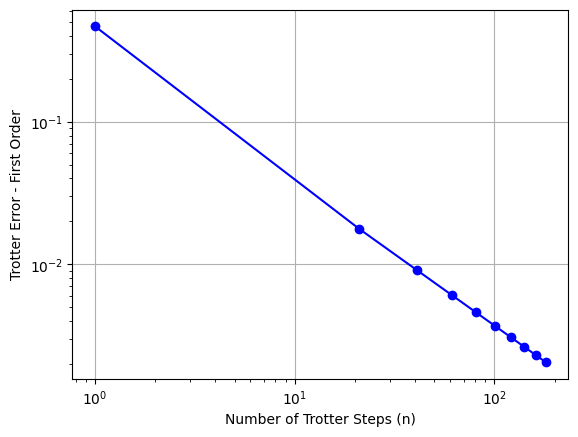

In [10]:
from pytket.extensions.qiskit import AerStateBackend
import matplotlib.pyplot as plt

def get_ising_circ_FO(n_qubits: int, J: float, g: float, t: float, N_trotter: int, q: float):
    '''
    Returns a circuit to simulate the Ising model via FIRST
    ORDER TROTTERIZATION (FOT) given the model's needed parameters
    and coefficient q. 
    '''

    H_ising = get_ising_FO_trotter(n_qubits=n_qubits, g=g, J=J, t=t, N_trotter=N_trotter, q=q)
    circ = Circuit(n_qubits)

    for _ in range(N_trotter):
        circ = gen_term_sequence_circuit(H_ising, circ)

    return circ
    
#########################################################
### PLOTTING TROTTER ERROR AS A FUNCTION OF N_trotter ###
#########################################################

trotter_errors_FO = []
n_qubits, g, J, t, q = 2, 1.0, 1.2, 1.0, 2/np.pi

for num_steps in n_trotter_steps:
    circ = Circuit(n_qubits)
    circ = get_ising_circ_FO(n_qubits, J, g, t, num_steps, q)

    backend = AerStateBackend()  # qiskit's state vector simulator
    compiled_circ = backend.get_compiled_circuit(circ)
    result = backend.process_circuit(compiled_circ)
    result = backend.get_result(result)

    approx_state = result.get_state()

    # the true ising state was calculated using qlib earlier.
    curr_error = np.max(np.abs(approx_state - true_ising_state.vector))
    trotter_errors_FO.append(curr_error)


plt.plot(n_trotter_steps, trotter_errors_FO, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Trotter Steps (n)')
plt.ylabel('Trotter Error - First Order')
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.show()

{(Zq[0], Zq[1]): -0.38197186342054884, (Xq[0]): 0.3183098861837907, (Xq[1]): 0.3183098861837907}
{(Zq[0], Zq[1]): -0.01818913635335947, (Xq[0]): 0.015157613627799557, (Xq[1]): 0.015157613627799557}
{(Zq[0], Zq[1]): -0.009316386912696314, (Xq[0]): 0.007763655760580261, (Xq[1]): 0.007763655760580261}
{(Zq[0], Zq[1]): -0.006261833826566374, (Xq[0]): 0.005218194855471979, (Xq[1]): 0.005218194855471979}
{(Zq[0], Zq[1]): -0.00471570201753764, (Xq[0]): 0.003929751681281367, (Xq[1]): 0.003929751681281367}
{(Zq[0], Zq[1]): -0.0037818996378272164, (Xq[0]): 0.00315158303152268, (Xq[1]): 0.00315158303152268}
{(Zq[0], Zq[1]): -0.0031567922596739575, (Xq[0]): 0.0026306602163949644, (Xq[1]): 0.0026306602163949644}
{(Zq[0], Zq[1]): -0.002709020307947155, (Xq[0]): 0.0022575169232892955, (Xq[1]): 0.0022575169232892955}
{(Zq[0], Zq[1]): -0.0023724960460903654, (Xq[0]): 0.001977080038408638, (Xq[1]): 0.001977080038408638}
{(Zq[0], Zq[1]): -0.002110341786853861, (Xq[0]): 0.0017586181557115508, (Xq[1]): 0.0

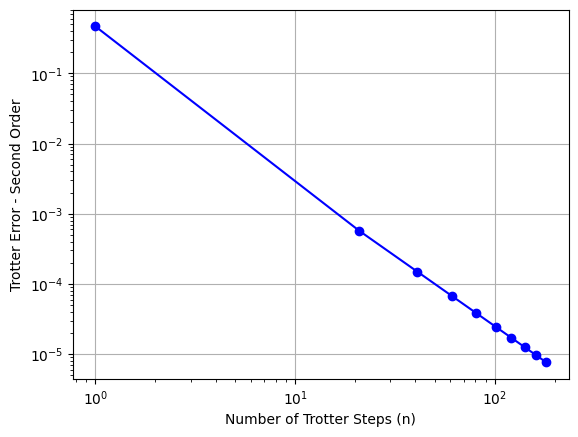

In [11]:
from pytket.extensions.qiskit import AerStateBackend
import matplotlib.pyplot as plt

def get_ising_circ_SO(n_qubits: int, J: float, g: float, t: float, N_trotter: int, q: float):
    '''
    Returns a circuit to simulate the Ising model via SOT 
    given the model's needed parameters and coefficient q. 
    '''

    H_ising_forward = get_ising_SO_trotter_FORWARD(n_qubits=n_qubits, g=g, J=J, t=t, N_trotter=N_trotter, q=q)
    H_ising_reverse = get_ising_SO_trotter_REVERSE(n_qubits=n_qubits, g=g, J=J, t=t, N_trotter=N_trotter, q=q)

    circ = Circuit(n_qubits)
    for _ in range(N_trotter): 
        circ = gen_term_sequence_circuit(H_ising_forward,circ)
        circ  = gen_term_sequence_circuit(H_ising_reverse, circ)
    return circ

#########################################################
### PLOTTING TROTTER ERROR AS A FUNCTION OF N_trotter ###
#########################################################

trotter_errors_SO = []
n_qubits, g, J, t, q = 2, 1.0, 1.2, 1.0, 2/np.pi

for num_steps in n_trotter_steps:
    circ = Circuit(n_qubits)
    circ = get_ising_circ_SO(n_qubits, J, g, t, num_steps, q)

    backend = AerStateBackend()  # qiskit's state vector simulator
    compiled_circ = backend.get_compiled_circuit(circ)
    result = backend.process_circuit(compiled_circ)
    result = backend.get_result(result)

    approx_state = result.get_state()

    # the true ising state was calculated using qlib earlier.
    curr_error = np.max(np.abs(approx_state - true_ising_state.vector))
    trotter_errors_SO.append(curr_error)


plt.plot(n_trotter_steps, trotter_errors_SO, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Trotter Steps (n)')
plt.ylabel('Trotter Error - Second Order')
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.show()

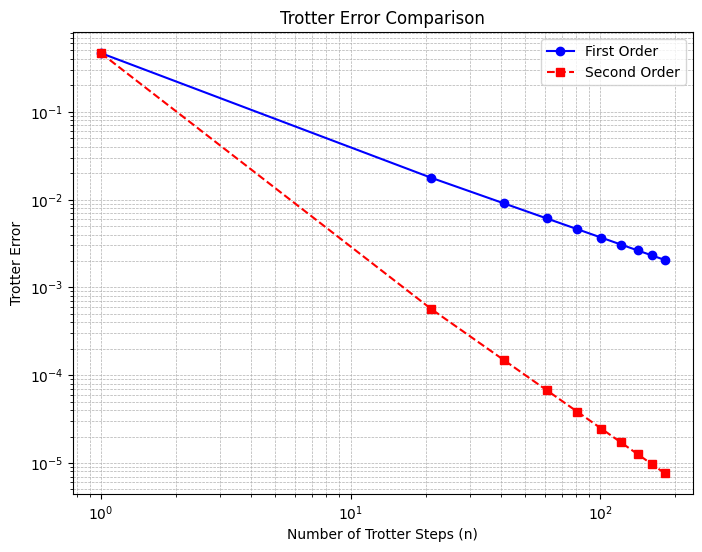

In [12]:
####################################
### PLOTTING BOTH TROTTER ERRORS ###
####################################

plt.figure(figsize=(8, 6))
plt.plot(n_trotter_steps, trotter_errors_FO, marker='o', linestyle='-', color='b', label='First Order')
plt.plot(n_trotter_steps, trotter_errors_SO, marker='s', linestyle='--', color='r', label='Second Order')

# labels + formatting
plt.xlabel('Number of Trotter Steps (n)')
plt.ylabel('Trotter Error')
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()  
plt.title('Trotter Error Comparison')
plt.show() 

### Task 3: Do the same for the XXZ model

What would you expect. Why is there no Trotter error?

In [13]:
def get_XXZ_FO_trotter(n_qubits: int, Delta_ZZ: float, t: float, N_trotter: int, q: float) -> QubitPauliOperator:
    '''
    Returns the XXZ model Hamiltonian given the number of qubits, 
    neighboring spin interaction strength Delta_ZZ, a time to propagate
    to t, and the number of trotter steps N_trotter. This uses a FIRST
    ORDER TROTTERIZATION. The parameter q is for scaling. 
    '''

    sites = nx.path_graph(n_qubits)
    qpo_dict = {}
    
    for e in sites.edges:  # Z^(n)Z^(n+1) terms
        zz_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Z, Pauli.Z])
        xx_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.X, Pauli.X])
        yy_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Y, Pauli.Y])
        qpo_dict[zz_term] = Delta_ZZ*q/N_trotter
        qpo_dict[xx_term] = 1.0*q/N_trotter
        qpo_dict[yy_term] = 1.0*q/N_trotter
    
    print(qpo_dict)
    return QubitPauliOperator(qpo_dict)

def get_XXZ_SO_trotter_FORWARD(n_qubits: int, Delta_ZZ: float, t: float, N_trotter: int, q: float) -> QubitPauliOperator:
    '''
    Returns the XXZ model Hamiltonian given the number of qubits, 
    neighboring spin interaction Delta_ZZ, a time to propagate
    to t, and the number of trotter steps N_trotter. This uses a SECOND
    ORDER TROTTERIZATION (SOC). This only calculates the first half of the terms
    in a SOC; 'get_XXZ_SO_trotter_REVERSE' does the second half. 
    The parameter q is for scaling. 
    '''

    sites = nx.path_graph(n_qubits)
    qpo_dict = {}

    for e in sites.edges: # Z > Y > X
        zz_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Z, Pauli.Z])
        xx_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.X, Pauli.X])
        yy_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Y, Pauli.Y])
        qpo_dict[zz_term] = Delta_ZZ*q/(2 * N_trotter)
        qpo_dict[xx_term] = 1.0*q/(2 * N_trotter)
        qpo_dict[yy_term] = 1.0*q/(2 * N_trotter)

    print(qpo_dict)
    return QubitPauliOperator(qpo_dict)

def get_XXZ_SO_trotter_REVERSE(n_qubits: int, Delta_ZZ: float, t: float, N_trotter: int, q: float) -> QubitPauliOperator:
    '''
    Returns the XXZ model Hamiltonian given the number of qubits, 
    neighboring spin interaction Delta_ZZ, a time to propagate
    to t, and the number of trotter steps N_trotter. This uses a SECOND
    ORDER TROTTERIZATION (SOC). This only calculates the second half of the terms
    in a SOC; 'get_ising_SO_trotter_FORWARD' does the first half. 
    The parameter q is for scaling. 
    '''
    sites = nx.path_graph(n_qubits)
    qpo_dict = {}
    
    for e in reversed(list(sites.edges)):
        yy_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Y, Pauli.Y])
        xx_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.X, Pauli.X])
        zz_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Z, Pauli.Z])
        qpo_dict[yy_term] = 1.0*q/(2 * N_trotter)
        qpo_dict[xx_term] = 1.0*q/(2 * N_trotter)
        qpo_dict[zz_term] = Delta_ZZ*q/(2 * N_trotter)
        
    return QubitPauliOperator(qpo_dict)

{(Zq[0], Zq[1]): 0.3183098861837907, (Xq[0], Xq[1]): 0.6366197723675814, (Yq[0], Yq[1]): 0.6366197723675814}
{(Zq[0], Zq[1]): 0.015157613627799557, (Xq[0], Xq[1]): 0.030315227255599115, (Yq[0], Yq[1]): 0.030315227255599115}
{(Zq[0], Zq[1]): 0.007763655760580261, (Xq[0], Xq[1]): 0.015527311521160521, (Yq[0], Yq[1]): 0.015527311521160521}
{(Zq[0], Zq[1]): 0.005218194855471979, (Xq[0], Xq[1]): 0.010436389710943957, (Yq[0], Yq[1]): 0.010436389710943957}
{(Zq[0], Zq[1]): 0.003929751681281367, (Xq[0], Xq[1]): 0.007859503362562734, (Yq[0], Yq[1]): 0.007859503362562734}
{(Zq[0], Zq[1]): 0.00315158303152268, (Xq[0], Xq[1]): 0.00630316606304536, (Yq[0], Yq[1]): 0.00630316606304536}
{(Zq[0], Zq[1]): 0.0026306602163949644, (Xq[0], Xq[1]): 0.005261320432789929, (Yq[0], Yq[1]): 0.005261320432789929}
{(Zq[0], Zq[1]): 0.0022575169232892955, (Xq[0], Xq[1]): 0.004515033846578591, (Yq[0], Yq[1]): 0.004515033846578591}
{(Zq[0], Zq[1]): 0.001977080038408638, (Xq[0], Xq[1]): 0.003954160076817276, (Yq[0], Yq

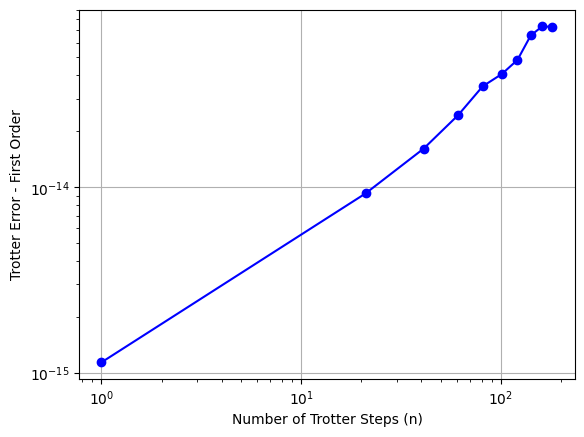

In [22]:
from pytket.extensions.qiskit import AerStateBackend
import matplotlib.pyplot as plt

def get_XXZ_circ_FO(n_qubits: int, Delta_ZZ: float, t: float, N_trotter: int, q: float):
    '''
    Returns a circuit to simulate the XXZ model via FIRST
    ORDER TROTTERIZATION (FOT) given the model's needed parameters
    and coefficient q. 
    '''

    H_XXZ = get_XXZ_FO_trotter(n_qubits=n_qubits, Delta_ZZ=Delta_ZZ, t=t, N_trotter=N_trotter, q=q)
    circ = Circuit(n_qubits)

    for _ in range(N_trotter):
        circ = gen_term_sequence_circuit(H_XXZ, circ)

    return circ
    
#########################################################
### PLOTTING TROTTER ERROR AS A FUNCTION OF N_trotter ###
#########################################################

trotter_errors_FO = []
n_qubits, Delta_ZZ, q = 2, 0.5, 2/np.pi

for num_steps in n_trotter_steps:
    circ = Circuit(n_qubits)
    circ = get_XXZ_circ_FO(n_qubits, Delta_ZZ, t, num_steps, q)

    backend = AerStateBackend()  # qiskit's state vector simulator
    compiled_circ = backend.get_compiled_circuit(circ)
    result = backend.process_circuit(compiled_circ)
    result = backend.get_result(result)

    approx_state = result.get_state()

    # the true XXZ state was calculated using qlib earlier.
    curr_error = np.max(np.abs(approx_state - true_XXZ_state.vector))
    trotter_errors_FO.append(curr_error)


plt.plot(n_trotter_steps, trotter_errors_FO, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Trotter Steps (n)')
plt.ylabel('Trotter Error - First Order')
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.show()

{(Zq[0], Zq[1]): 0.15915494309189535, (Xq[0], Xq[1]): 0.3183098861837907, (Yq[0], Yq[1]): 0.3183098861837907}
{(Zq[0], Zq[1]): 0.007578806813899779, (Xq[0], Xq[1]): 0.015157613627799557, (Yq[0], Yq[1]): 0.015157613627799557}
{(Zq[0], Zq[1]): 0.0038818278802901303, (Xq[0], Xq[1]): 0.007763655760580261, (Yq[0], Yq[1]): 0.007763655760580261}
{(Zq[0], Zq[1]): 0.0026090974277359893, (Xq[0], Xq[1]): 0.005218194855471979, (Yq[0], Yq[1]): 0.005218194855471979}
{(Zq[0], Zq[1]): 0.0019648758406406834, (Xq[0], Xq[1]): 0.003929751681281367, (Yq[0], Yq[1]): 0.003929751681281367}
{(Zq[0], Zq[1]): 0.00157579151576134, (Xq[0], Xq[1]): 0.00315158303152268, (Yq[0], Yq[1]): 0.00315158303152268}
{(Zq[0], Zq[1]): 0.0013153301081974822, (Xq[0], Xq[1]): 0.0026306602163949644, (Yq[0], Yq[1]): 0.0026306602163949644}
{(Zq[0], Zq[1]): 0.0011287584616446477, (Xq[0], Xq[1]): 0.0022575169232892955, (Yq[0], Yq[1]): 0.0022575169232892955}
{(Zq[0], Zq[1]): 0.000988540019204319, (Xq[0], Xq[1]): 0.001977080038408638, (Y

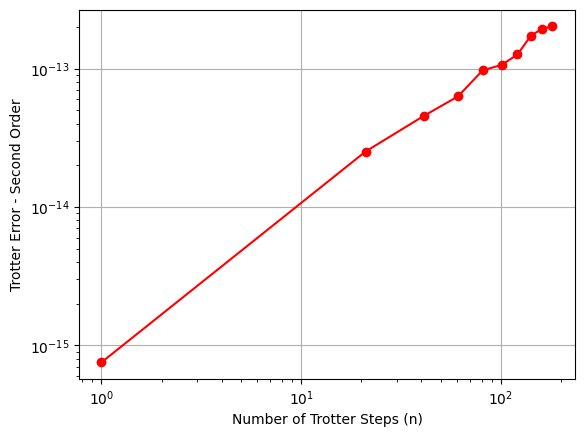

In [23]:
from pytket.extensions.qiskit import AerStateBackend
import matplotlib.pyplot as plt

def get_XXZ_circ_SO(n_qubits: int, Delta_ZZ: float, t: float, N_trotter: int, q: float):
    '''
    Returns a circuit to simulate the XXZ model via SOT 
    given the model's needed parameters and coefficient q. 
    '''

    H_XXZ_forward = get_XXZ_SO_trotter_FORWARD(n_qubits=n_qubits, Delta_ZZ=Delta_ZZ, t=t, N_trotter=N_trotter, q=q)
    H_XXZ_reverse = get_XXZ_SO_trotter_REVERSE(n_qubits=n_qubits, Delta_ZZ=Delta_ZZ, t=t, N_trotter=N_trotter, q=q)

    circ = Circuit(n_qubits)
    for _ in range(N_trotter): 
        circ = gen_term_sequence_circuit(H_XXZ_forward,circ)
        circ  = gen_term_sequence_circuit(H_XXZ_reverse, circ)
    return circ

#########################################################
### PLOTTING TROTTER ERROR AS A FUNCTION OF N_trotter ###
#########################################################

trotter_errors_SO = []
n_qubits, Delta_ZZ, t, q = 2, 0.5, 1.0, 2/np.pi

for num_steps in n_trotter_steps:
    circ = Circuit(n_qubits)
    circ = get_XXZ_circ_SO(n_qubits, Delta_ZZ, t, num_steps, q)

    backend = AerStateBackend()  # qiskit's state vector simulator
    compiled_circ = backend.get_compiled_circuit(circ)
    result = backend.process_circuit(compiled_circ)
    result = backend.get_result(result)

    approx_state = result.get_state()

    # the true ising state was calculated using qlib earlier.
    curr_error = np.max(np.abs(approx_state - true_XXZ_state.vector))
    trotter_errors_SO.append(curr_error)


plt.plot(n_trotter_steps, trotter_errors_SO, marker='o', linestyle='-', color='r')
plt.xlabel('Number of Trotter Steps (n)')
plt.ylabel('Trotter Error - Second Order')
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.show()

In [ ]:
### With an initial state of all zeros in the XXZ model, the components of the Hamiltonian commute. Because of this, there should be zero trotter error.

### Task 4: Influence of noise

As a next step, we study the influence of noise. Using Quantinuum noise models, we can simulate the circuit under approximately realistic conditions. We focus on the transverse field Ising model in the following.

In general, there will be a trade-off between Trotter error and noise. Smaller Trotter steps will reduce the Trotter error but also increase the circuit complexity, e.g. the number of two-qubit gates. This will generally increase errors coming from the noisy hardware.

Explore this trade-off by simulating the Trotter circuit for varied Trotter step sizes and noise parameters.

### Task 5: Other Hamiltonians

You can try to implement other Hamiltonians you can find in the literature.

## Section 2: Simulating quantum systems

In the following we study several physically interesting cases of quantum system dynamics for the XXZ Hamiltonian.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from pytket.utils.expectations import get_operator_expectation_value
from pytket.extensions.qiskit import AerBackend
import time

aer_sim = AerBackend()

Let's first define our Hamiltonian again. We focus on the XXZ Heisenberg model here.

In [ ]:
n_qubits = 5
Delta_ZZ = 1.72

xxz_ham = get_xxz_chain_hamiltonian(n_qubits=n_qubits, Delta_ZZ=Delta_ZZ)
print(xxz_ham)

### Task 1: Energy conservation

The expectation value of the Hamiltonian $H$ gives the energy of the system. This energy does not change during unitary time evolution of the system, i.e. if the initial state has energy $E$, the energy of the system will be $E$ for all times.

Below we will test how good our Trotterized circuit fulfills energy conservation.

We start by computing the energy of the initial zero state $\ket{\psi} = \ket{0}^{\otimes N}$. This is the default initial state if one generates an empty circuit without any further gates. We compute the expectation of $H$ using the `pytket` function `get_operator_expectation_value`. For simulating the (empty) circuit simulation we use the AerBackend and choose 1000 shots. The expectation value of any Hermitian operator is real. Because we are doing numerics, there might be a negligible imaginary part of order machine precision, which we can just discard.

In [ ]:
n_qubits = 5
n_shots = 1000

initial_state_circtuit = Circuit(n_qubits=n_qubits, name="Initial state")
energy = get_operator_expectation_value(initial_state_circtuit, xxz_ham, aer_sim, n_shots=n_shots)
print("Energy:", energy.real)

Test how the energy is changing if you apply a few simple gates before you compute the expectation value with `get_operator_expectation_value`.

Next we check if the energy is conserved under system evolution.
- Use `t_max = 20`, discretize the interval `[1, t_max]` into several steps, e.g. `times = np.linspace(1, 20, 5)`, and generate the time evolution circuit for each `t` in `times`. You can use e.g. $\Delta t = 3$.
- Use `time_evolution_circ_compiled = aer_sim.get_compiled_circuit(time_evolution_circ, optimisation_level = 2)` to compile and optimize the circuit. Optimization will result in shorter simulation times.
- Monitor the number of two-qubit gates of the compiled and uncompiled circuits as you change `t`. You get this number in pytket via `circ.2_qb_gates()`.
- Compute the energy expectation at the output of each of those circuits. You can use a smaller number of shots, e.g. `n_shots = 100`, for this.
- Plot the obtained energy expectation values against `times`.

Hints:
- To get two-qubit gate counts of the uncompiled circuit, you will probably need to decompose all boxes with `DecomposeBoxes().apply(time_evolution_circ)` before getting the gate count with `time_evolution_circ.n_2qb_gates()`.
- As you will see, the optimization during compilation significantly reduces the two-qubit gate count. This will reduce the time it requires to simulate the circuit classically. Therefore, it is usually a good idea to optimize circuits before running them on either a classical simulator or actual quantum hardware.
- You can also monitor the time to compute the expectation values for varied `t`. Plot these timings and the number of two-qubit gates versus `times`.
- The energy expectation should roughly be the same for each `t` in `times`, i.e. stay constant.

{(Zq[0], Zq[1]): -3.0557749073643903, (Zq[1], Zq[2]): -3.0557749073643903, (Zq[2], Zq[3]): -3.0557749073643903, (Zq[3], Zq[4]): -3.0557749073643903, (Zq[4], Zq[5]): -3.0557749073643903, (Zq[5], Zq[6]): -3.0557749073643903, (Zq[6], Zq[7]): -3.0557749073643903, (Zq[7], Zq[8]): -3.0557749073643903, (Zq[8], Zq[9]): -3.0557749073643903, (Xq[0]): 2.5464790894703255, (Xq[1]): 2.5464790894703255, (Xq[2]): 2.5464790894703255, (Xq[3]): 2.5464790894703255, (Xq[4]): 2.5464790894703255, (Xq[5]): 2.5464790894703255, (Xq[6]): 2.5464790894703255, (Xq[7]): 2.5464790894703255, (Xq[8]): 2.5464790894703255, (Xq[9]): 2.5464790894703255}
{(Zq[0], Zq[1]): -0.15278874536821954, (Zq[1], Zq[2]): -0.15278874536821954, (Zq[2], Zq[3]): -0.15278874536821954, (Zq[3], Zq[4]): -0.15278874536821954, (Zq[4], Zq[5]): -0.15278874536821954, (Zq[5], Zq[6]): -0.15278874536821954, (Zq[6], Zq[7]): -0.15278874536821954, (Zq[7], Zq[8]): -0.15278874536821954, (Zq[8], Zq[9]): -0.15278874536821954, (Xq[0]): 0.12732395447351627, (Xq

/opt/conda/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/conda/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


{(Zq[0], Zq[1]): -0.21220659078919374, (Zq[1], Zq[2]): -0.21220659078919374, (Zq[2], Zq[3]): -0.21220659078919374, (Zq[3], Zq[4]): -0.21220659078919374, (Zq[4], Zq[5]): -0.21220659078919374, (Zq[5], Zq[6]): -0.21220659078919374, (Zq[6], Zq[7]): -0.21220659078919374, (Zq[7], Zq[8]): -0.21220659078919374, (Zq[8], Zq[9]): -0.21220659078919374, (Xq[0]): 0.17683882565766146, (Xq[1]): 0.17683882565766146, (Xq[2]): 0.17683882565766146, (Xq[3]): 0.17683882565766146, (Xq[4]): 0.17683882565766146, (Xq[5]): 0.17683882565766146, (Xq[6]): 0.17683882565766146, (Xq[7]): 0.17683882565766146, (Xq[8]): 0.17683882565766146, (Xq[9]): 0.17683882565766146}
{(Zq[0], Zq[1]): -0.37348359978898105, (Zq[1], Zq[2]): -0.37348359978898105, (Zq[2], Zq[3]): -0.37348359978898105, (Zq[3], Zq[4]): -0.37348359978898105, (Zq[4], Zq[5]): -0.37348359978898105, (Zq[5], Zq[6]): -0.37348359978898105, (Zq[6], Zq[7]): -0.37348359978898105, (Zq[7], Zq[8]): -0.37348359978898105, (Zq[8], Zq[9]): -0.37348359978898105, (Xq[0]): 0.311

/opt/conda/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/conda/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


{(Zq[0], Zq[1]): -0.12732395447351624, (Zq[1], Zq[2]): -0.12732395447351624, (Zq[2], Zq[3]): -0.12732395447351624, (Zq[3], Zq[4]): -0.12732395447351624, (Zq[4], Zq[5]): -0.12732395447351624, (Zq[5], Zq[6]): -0.12732395447351624, (Zq[6], Zq[7]): -0.12732395447351624, (Zq[7], Zq[8]): -0.12732395447351624, (Zq[8], Zq[9]): -0.12732395447351624, (Xq[0]): 0.10610329539459688, (Xq[1]): 0.10610329539459688, (Xq[2]): 0.10610329539459688, (Xq[3]): 0.10610329539459688, (Xq[4]): 0.10610329539459688, (Xq[5]): 0.10610329539459688, (Xq[6]): 0.10610329539459688, (Xq[7]): 0.10610329539459688, (Xq[8]): 0.10610329539459688, (Xq[9]): 0.10610329539459688}
{(Zq[0], Zq[1]): -0.22409015987338862, (Zq[1], Zq[2]): -0.22409015987338862, (Zq[2], Zq[3]): -0.22409015987338862, (Zq[3], Zq[4]): -0.22409015987338862, (Zq[4], Zq[5]): -0.22409015987338862, (Zq[5], Zq[6]): -0.22409015987338862, (Zq[6], Zq[7]): -0.22409015987338862, (Zq[7], Zq[8]): -0.22409015987338862, (Zq[8], Zq[9]): -0.22409015987338862, (Xq[0]): 0.186

/opt/conda/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/conda/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


{(Zq[0], Zq[1]): -0.09094568176679732, (Zq[1], Zq[2]): -0.09094568176679732, (Zq[2], Zq[3]): -0.09094568176679732, (Zq[3], Zq[4]): -0.09094568176679732, (Zq[4], Zq[5]): -0.09094568176679732, (Zq[5], Zq[6]): -0.09094568176679732, (Zq[6], Zq[7]): -0.09094568176679732, (Zq[7], Zq[8]): -0.09094568176679732, (Zq[8], Zq[9]): -0.09094568176679732, (Xq[0]): 0.07578806813899777, (Xq[1]): 0.07578806813899777, (Xq[2]): 0.07578806813899777, (Xq[3]): 0.07578806813899777, (Xq[4]): 0.07578806813899777, (Xq[5]): 0.07578806813899777, (Xq[6]): 0.07578806813899777, (Xq[7]): 0.07578806813899777, (Xq[8]): 0.07578806813899777, (Xq[9]): 0.07578806813899777}
{(Zq[0], Zq[1]): -0.1600643999095633, (Zq[1], Zq[2]): -0.1600643999095633, (Zq[2], Zq[3]): -0.1600643999095633, (Zq[3], Zq[4]): -0.1600643999095633, (Zq[4], Zq[5]): -0.1600643999095633, (Zq[5], Zq[6]): -0.1600643999095633, (Zq[6], Zq[7]): -0.1600643999095633, (Zq[7], Zq[8]): -0.1600643999095633, (Zq[8], Zq[9]): -0.1600643999095633, (Xq[0]): 0.133386999924

/opt/conda/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/conda/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


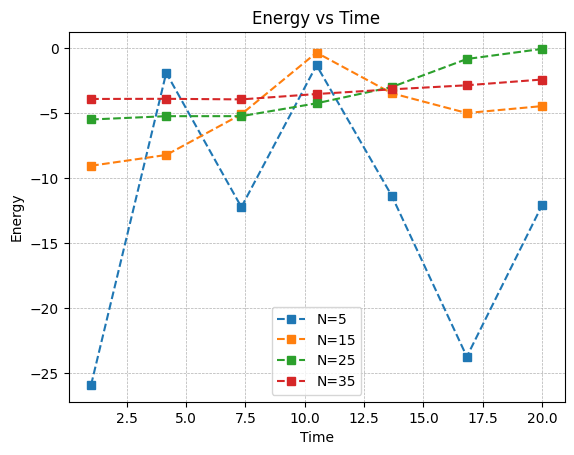

In [27]:
n_qubits = 10

t_max = 20
n_shots = 1000
times = np.linspace(1, t_max, 7)

trotter_step_size = [5,15,25,35]

aer_sim = AerBackend()



for N in trotter_step_size:
    energies= []
    ising_ham = get_ising_FO_trotter(n_qubits=n_qubits, J=1.2, g=1.0, t=t, N_trotter=N, q=2/np.pi)
    
    for t in times:
        circ = Circuit(n_qubits)
        circ = get_ising_circ_FO(n_qubits=n_qubits, J=1.2, g=1.0, t=t, N_trotter=N, q=2/np.pi)
        energies.append(get_operator_expectation_value(circ, ising_ham, aer_sim, n_shots=n_shots))
    
    print(f'Number of 2 qubit gates: {circ.n_2qb_gates()}')

    plt.plot(times, energies, marker='s', linestyle='--', label=f'N={N}')

# Labels and formatting
plt.xlabel('Time')
plt.ylabel('Energy')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()  # Show legend to differentiate curves
plt.title('Energy vs Time')
plt.show()


### Task 2: Influence of noise

Study how hardware noise, emulated with e.g. the Quantinuum noise models, affects the results.

In [46]:
import datetime
import qnexus as qnx

project = qnx.projects.get_or_create(name="iQuHACK2025-jtejada")
qnx.context.set_active_project(project)

jobname_suffix = datetime.datetime.now().strftime("%Y_%m_%d-%H-%M-%S")
h1_config = qnx.QuantinuumConfig(device_name="H1-Emulator")

In [50]:
n_qubits=2
N=3
circuit = get_ising_circ_FO(n_qubits=n_qubits, J=1.2, g=1.0, t=t, N_trotter=N, q=2/np.pi)
ref = qnx.circuits.upload(circuit=circuit, name=f"GHZ-Circuit-{jobname_suffix}")

{(Zq[0], Zq[1]): -0.25464790894703254, (Xq[0]): 0.2122065907891938, (Xq[1]): 0.2122065907891938}


In [51]:
draw(ref.download_circuit())

In [53]:
ref_compile_job = qnx.start_compile_job(
    circuits=[ref],
    backend_config=h1_config,
    optimisation_level=2,
    name=f"compilation-job-{jobname_suffix}"
)

In [54]:
qnx.jobs.wait_for(ref_compile_job)
ref_compiled_circuit = qnx.jobs.results(ref_compile_job)[0].get_output()

In [55]:
compiled_circuit = ref_compiled_circuit.download_circuit()

draw(compiled_circuit)

In [56]:
ref_execute_job = qnx.start_execute_job(
    circuits=[ref_compiled_circuit],
    n_shots=[100],
    backend_config=h1_config,
    name=f"execution-job-{jobname_suffix}"
)

In [57]:
qnx.jobs.status(ref_execute_job)

JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2025, 2, 2, 7, 26, 8, 878630, tzinfo=datetime.timezone.utc), queued_time=None, submitted_time=datetime.datetime(2025, 2, 2, 7, 26, 8, 50329, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2025, 2, 2, 7, 26, 8, 488997, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)

In [58]:
qnx.jobs.wait_for(ref_execute_job)
ref_result = qnx.jobs.results(ref_execute_job)[0]
backend_result = ref_result.download_result()

In [59]:
print(backend_result.get_counts())

Counter({(0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0): 100})


### Task 3: Hamiltonian system dynamics

Compute time dependent expectation values for other observable, for example $X^{(i)}$ for one of the qubits $i$, or a correlator $X^{(i)} X^{(j)}$. Would you expect these expectation values to vary in time?

### Task 4: Hamiltonian system dynamics

Diagonalise the Hamiltonian numerically and obtain two eigenstates with different energies, for example take eigenstates of the two lowest energy levels. Use build-in functionality, such as pytket's `StatePreparationBox` to prepare a uniform superposition $\ket{\psi}$ of both states with a quantum circuit.

Simulate the time evolution of the expectation value of $Z_i$ (or any other easy observable) with $\ket{\psi}$ as initial state, and plot the time evolution. What do you expect? How does the frequency of oscillation relate to the energy levels of the Hamiltonian?

In [16]:
import numpy as np
from scipy.linalg import expm
from pytket import Circuit
from pytket.extensions.qiskit import AerBackend
from pytket.passes import FullPeepholeOptimise
from pytket.circuit import StatePreparationBox
import matplotlib.pyplot as plt

# Define Pauli Matrices
I = np.eye(4)
X1 = np.kron(np.array([[0, 1], [1, 0]]), I[::2, ::2])
Z1 = np.kron(np.array([[1, 0], [0, -1]]), I[::2, ::2])
Z2 = np.kron(I[::2, ::2], np.array([[1, 0], [0, -1]]))

# Define Hamiltonian: H = J Z1 Z2 + h X1
J = 1.0
h = 0.5
H = J * np.kron(Z1, Z2) + h * np.kron(X1, I)

# Diagonalize the Hamiltonian
eigenvalues, eigenvectors = np.linalg.eigh(H)

# Extract lowest two energy eigenstates
ground_state = eigenvectors[:, 0]   # Corresponding to lowest eigenvalue
first_excited_state = eigenvectors[:, 1]  # Corresponding to second-lowest eigenvalue

# Print eigenvalues
print(f"Eigenvalues: {eigenvalues[:2]}")  # Lowest two energy levels
print(f"Eigenvectors: {ground_state}") 

sum_state=(ground_state + first_excited_state)/(2**(1/2))
print(f"{sum_state}")

Eigenvalues: [-1.11803399 -1.11803399]
Eigenvectors: [-0.22975292  0.          0.          0.          0.          0.
  0.          0.          0.97324899 -0.         -0.         -0.
 -0.         -0.         -0.         -0.        ]
[-0.16245985  0.         -0.16245985  0.          0.          0.
  0.          0.          0.68819096  0.          0.68819096 -0.
 -0.         -0.         -0.         -0.        ]


In [17]:
state = StatePreparationBox(sum_state)
state.get_statevector()

array([-0.16245985+0.j,  0.        +0.j, -0.16245985+0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.68819096+0.j,  0.        +0.j,  0.68819096+0.j, -0.        +0.j,
       -0.        +0.j, -0.        +0.j, -0.        +0.j, -0.        +0.j])

In [18]:
circ = get_ising_circ_FO(n_qubits=4, J=1.2, g=1.0, t=t, N_trotter=3, q=2/np.pi)
draw(circ)

{(Zq[0], Zq[1]): -0.25464790894703254, (Zq[1], Zq[2]): -0.25464790894703254, (Zq[2], Zq[3]): -0.25464790894703254, (Xq[0]): 0.2122065907891938, (Xq[1]): 0.2122065907891938, (Xq[2]): 0.2122065907891938, (Xq[3]): 0.2122065907891938}


In [19]:
final_circuit = state.get_circuit()
qubits = final_circuit.qubits
final_circuit.add_circuit(circ, qubits)
draw(final_circuit)

### Task 5: Time evolution of the Ising model

You can explore the above tasks for the Ising model instead of the XXZ model. Since the Ising model suffers Trotterization error, you might find that this model conserves energy less accurate as the XXZ model.